<a href="https://colab.research.google.com/github/kdemertzis/EKPA/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου PyOD (https://pyod.readthedocs.io/en/latest/)
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=95250b3dd357d08469d8bca63574b72a40628cdb67ca96a9eff4813b245aebcb
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyod.models.ecod import ECOD # Use ECOD, as it is case-sensitive
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#εισαγωγή του συνόλου δεδομένων
network_data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv', delimiter=',')

<ipython-input-3-4fb33df0a72e>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  network_data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv', delimiter=',')


In [4]:
#εξαγωγή χαρακτηριστικών (ανεξάρτητων μεταβλητών) για την αναγνώριση ανωμαλιών
features = ['Src_Port', 'Dst_IP', 'Dst_Port', 'Flow_Duration',
            'Label-1', 'Src_IP', 'Total_Fwd_Packet', 'Total_Length_of_Fwd_Packet']

X = network_data[features].values

In [5]:
#εισαγωγή χαρακτηριστικών (ανεξάρτητων μεταβλητών) για την αναγνώριση ανωμαλιών
features = ['Src_Port', 'Dst_Port', 'Flow_Duration',
            'Total_Fwd_Packet', 'Total_Length_of_Fwd_Packet'] # Removed 'Label-1' as it contains non-numeric data

X = network_data[features].values

#κλιμάκωση δεδομένων
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
#χρήση αλγορίθμου ecod
model = ECOD(contamination=0.05)
model.fit(X_scaled)

ECOD(contamination=0.05, n_jobs=1)

In [8]:
# πρόβλεψη βαθμού ανωμαλίας
anomaly_scores = model.decision_function(X_scaled)

In [9]:
#προσθήκη βαθμού ανωμαλίας (anomaly score) στο σύνολο δεδομένων
network_data['anomaly_score'] = anomaly_scores

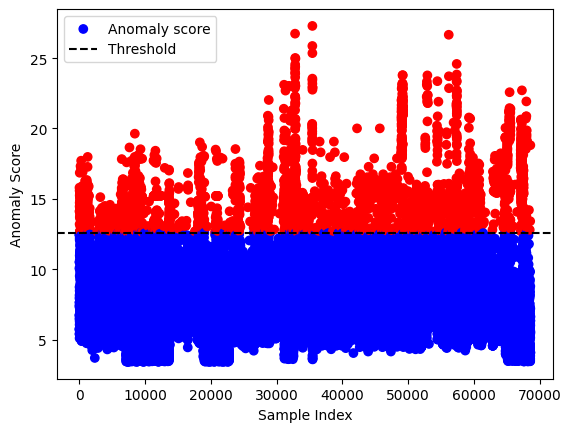

In [10]:
#οπτικοποίηση αποτελεσμάτων, με μπλε οι τιμές που θεωρούνται κανονικές και με κόκκινο όσες καταγράφονται ως ανωμαλίες
colors = ['blue' if score <= model.threshold_ else 'red' for score in anomaly_scores]

plt.scatter(network_data.index, anomaly_scores, c=colors, label='Anomaly score')
plt.axhline(y=model.threshold_, color='black', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()

In [11]:
#τύπωση των τιμών που εντοπίσθηκαν ως ανωμαλίες
anomalies = network_data[network_data['anomaly_score'] > model.threshold_]
print("Detected Anomalies:")
print(anomalies)

Detected Anomalies:
               Src_IP  Src_Port          Dst_IP  Dst_Port  Protocol  \
6       173.194.33.97       443   10.152.152.11     56254         6   
9       10.152.152.11     34702  173.194.65.127     19305         6   
24      10.152.152.11     57361  216.58.216.142       443         6   
26      173.194.33.97       443   10.152.152.11     56254         6   
27      10.152.152.11     34702  173.194.65.127     19305         6   
...               ...       ...             ...       ...       ...   
68032         8.6.0.1         0         8.0.6.4         0         0   
68363     46.17.57.54         0      10.8.8.246         0         0   
68487      10.8.8.246         0      224.0.0.22         0         0   
68556  80.239.235.110     11666      10.8.8.246     60245        17   
68579  80.239.235.110     11666      10.8.8.246     60245        17   

       Flow_Duration  Total_Fwd_Packet  Total_Bwd_packets  \
6          119682119               488                487   
9    